<div class="notebook-buttons" style="display:flex; padding-top: 5rem;padding-bottom: 2.5rem;line-height: 2.15;">
    <a href="https://colab.research.google.com/github/magdasalatka/fantastic-features/blob/main/main.ipynb">
        <div id="colab-link" style="display: flex;padding-right: 3.5rem;padding-bottom: 0.625rem;border-bottom: 1px solid #ececed; align-items: center;">
            <img class="call-to-action-img" src="img/colab.svg" width="30" height="30" style="margin-right: 10px;margin-top: auto;margin-bottom: auto;">
            <div class="call-to-action-txt">Run in Google Colab</div>
        </div>
    </a>
    <a href="https://raw.githubusercontent.com/magdasalatka/fantastic-features/main/main.ipynb" download>
        <div id="download-link" style="display: flex;padding-right: 3.5rem;padding-bottom: 0.625rem;border-bottom: 1px solid #ececed; height: auto;align-items: center;">
            <img class="call-to-action-img" src="img/download.svg" width="22" height="30" style="margin-right: 10px;margin-top: auto;margin-bottom: auto;">
            <div class="call-to-action-txt">Download Notebook</div>
        </div>
    </a>
    <a href="https://github.com/magdasalatka/fantastic-features/blob/main/main.ipynb">
        <div id="github-link" style="display: flex;padding-right: 3.5rem;padding-bottom: 0.625rem;border-bottom: 1px solid #ececed; height: auto;align-items: center;">
            <img class="call-to-action-img" src="img/github.svg" width="25" height="30" style="margin-right: 10px;margin-top: auto;margin-bottom: auto;">
            <div class="call-to-action-txt">View on GitHub</div>
        </div>
    </a>
</div>

# Back to the Feature
### Statistical feature engineering

In [1]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import statsmodels.api as sm
import statsmodels.graphics as sg
from typing import Tuple, List, Optional
import math


from sklearn.datasets import make_regression
from dataset_noise_generator import *

C:\Users\TK\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [117]:
def plot_x_vs_y(x: np.ndarray, y: np.ndarray, x_name: str = 'x_name', y_name: str = 'y_name', 
                         add_zero_line: bool = False, add_lowess: bool = False, 
                         model = None, hexbin: bool = False, 
                         figsize = None, ax = None, lowess_param = 0.2, plot_args = {}) -> None:
    if ax is None: 
        _, axs = plt.subplots(1, 1, figsize=figsize, constrained_layout=True)
        this_ax = axs
    else:
        this_ax = ax
    
    if hexbin: 
        this_ax.hexbin(x, y, cmap="Greys", gridsize=40, **plot_args)
    else: 
        scatter_defaults = {'alpha': 0.25, 's': 20, 'edgecolors':None}
        for k,v in scatter_defaults.items():
            if k not in plot_args.keys():
                plot_args[k] = v        
        this_ax.scatter(x, y, lw=0, **plot_args)

    xlabel = x_name
    this_ax.set_xlabel(xlabel)
    this_ax.set_ylabel(y_name)
    this_ax.grid(True)
    if add_zero_line:
        this_ax.hlines(0, xmin=min(x), xmax=max(x), colors="magenta")
    if add_lowess: 
        sorted_xy = np.array(sorted(zip(x,y))).T
        sorted_x = sorted_xy[0,:]
        sorted_y = sorted_xy[1,:]
        smoothed = sm.nonparametric.lowess(exog=sorted_x, endog=sorted_y, frac=lowess_param)
#         print(smoothed.shape)
        this_ax.plot(smoothed[:,0],smoothed[:,1],lw=1,color='k')

    return this_ax

def plot_multiple_x_vs_y(X: np.ndarray, y: np.ndarray, x_name: str, y_name: str, 
                         add_regression_line: bool = False, add_zero_line: bool =False, 
                         model = None, hexbin: bool = False, n_col:int = 2,
                         figsize = None, plot_args = {}) -> None:

    if add_regression_line and (model is None):
        predictors = sm.add_constant(X)
        model = sm.OLS(y, predictors).fit()

    if len(X.shape)>1:
        n_vars = X.shape[1]
    else: 
        n_vars = 1
        X = X.reshape((len(X),1)) # otherwise X.T will enumerate the list element-wise
    
    n_row = math.ceil(n_vars/n_col)
    if figsize is None: 
        subplot_size = (3,3)
        figsize = (n_col*subplot_size[0], n_row*subplot_size[1])
    _, axs = plt.subplots(n_row, n_col, figsize=figsize, constrained_layout=True)

    for i, x in enumerate(X.T):
        row = i//n_col
        col = i%n_col
        
        if (n_vars == 1) and (n_col == 1) : 
            this_ax = axs
        elif n_row == 1: 
            this_ax = axs[col]
        else: 
            this_ax = axs[row,col]

        if n_vars > 1: 
            xlabel = "{} {}".format(x_name, i)
        else: 
            xlabel = x_name
            
        plot_x_vs_y(x=x, y=y, x_name=xlabel, y_name=y_name, 
                         add_zero_line= add_zero_line, 
                         model = model, hexbin = hexbin, 
                         figsize = figsize, ax = this_ax, plot_args=plot_args)     

        if add_regression_line and (model is not None):
            x_vals = np.array(this_ax.get_xlim())
            y_vals = model.params[0] + model.params[i+1] * x_vals
            this_ax.plot(x_vals, y_vals, '--', color="orange")
        
    return axs

# Let's extend our plot_fitted_vs_residuals function
def plot_fitted_vs_residuals(fitted: np.ndarray, residuals: np.ndarray, 
                             mean: bool=True, 
                             width = 100, 
                          bin_type = None, ax=None) -> None:

    ax = plot_x_vs_y(fitted, residuals, "Fitted", "Residuals", ax=ax)
    
    if mean:
        ax.hlines(0, xmin=min(fitted), xmax=max(fitted), colors="orange")
    if bin_type == "window":
        ax.vlines(np.arange(min(fitted), max(fitted)+width, width), 
                  ymin=min(residuals), ymax=max(residuals), colors="red")
    elif bin_type == "points": 
        width = round(width)
        ax.vlines(np.sort(fitted)[::width], 
                      ymin=min(residuals), ymax=max(residuals), colors="red")
    ax.set_title('Fitted vs Residuals')

def calculate_variances(fitted: np.ndarray, residuals: np.ndarray, width = 100, bin_type="window") -> List[float]:
    
    sorted_residuals = [x for _, x in sorted(zip(fitted, residuals))]
    
    if bin_type == "points":
        width = round(width)
        
    if bin_type == "window":
        bins = np.arange(min(fitted), max(fitted)+width, width)
        digitized = np.digitize(fitted, bins)
        counts = [len(residuals[digitized == i]) for i in range(1, len(bins))]
        variances = [np.var(residuals[digitized == i]) for i in range(1, len(bins))]
        bins = bins[:-1]
    elif bin_type == "points": 
        start = 0
        variances = []
        starts = []
        counts = []
        while start+width < len(sorted_residuals):
            starts.append(start)
            cut = sorted_residuals[start:start+width]
            variances.append(np.var(cut))
            counts.append(len(cut))
            start += width
        # TODO: check if np.var is sample variance
        cut = sorted_residuals[start:]
        starts.append(start)
        variances.append(np.var(cut))
        counts.append(len(cut))
        bins = np.sort(fitted)[starts]
        
    else: 
        print("unknown bin type, possible values are ['window' , 'points' ]")
        variances = []
        bins = []
        counts = []
        
    return np.array(bins),np.array(variances),np.array(counts)

def plot_residuals_distribution(residuals: np.ndarray, bins:int=50, ax=None, figsize=None) -> None:
    
    if ax is None: 
        _, axs = plt.subplots(1, 1, figsize=figsize, constrained_layout=True)
        this_ax = axs
    else:
        this_ax = ax
    
    this_ax.hist(residuals, bins, density=True, facecolor='g', alpha=0.75)

    this_ax.set_xlabel('Error')
    this_ax.set_ylabel('Probability')
    this_ax.set_title('Residuals: empirical distribution')
    return ax


def plot_x_over_time(x: np.ndarray, x_name: str, ax=None) -> None:

    if ax is None: 
        _, ax = plt.subplots(figsize=(12,8))
    ax.set_xlabel("Time")
    ax.set_ylabel(x_name)
    ax.plot(range(len(x)), x, 'b-')
    ax.set_title("{} vs Time".format(x_name))


In [157]:
def train_xy(X,y,th_prop=0.8):
    threshold = int(len(X)*th_prop)
    X_train, X_test = X[:threshold], X[threshold:]
    y_train, y_test = y[:threshold], y[threshold:]

    predictors = sm.add_constant(X_train)
    model = sm.OLS(y_train, predictors).fit()
    fitted = model.predict(predictors)

    return X_train, y_train, model, fitted 

def draw_dashboard(X_train,y_train,fitted,variances_width=100,variances_bin_type="window"):
    residuals_raw = fitted - y_train
    residuals = residuals_raw/np.std(residuals_raw)
    print("Expected error estimate: {}".format(sum(residuals)/len(residuals)))
    error_estimate = sum(residuals)/len(residuals)

    bins, variances, counts = calculate_variances(fitted, residuals, width=variances_width, bin_type=variances_bin_type)
    # for v in variances:
    #     print(v)


    fig,ax = plt.subplots(ncols = 4, nrows = 2, figsize=(12,6), constrained_layout=True)

    this_ax = ax[0,0]
    plot_x_vs_y(fitted, residuals_raw, "Fitted", "Residuals", add_zero_line=True, add_lowess=True, ax=this_ax)
    this_ax.set_title('residuals_raw vs fit')
    xs = this_ax.get_xlim()
    this_ax.hlines(error_estimate, xs[0], xs[1])

    this_ax = ax[0,1]
    plot_fitted_vs_residuals(fitted, residuals, mean=False, width=variances_width, bin_type=variances_bin_type, ax=this_ax)
    resid_xlim = this_ax.get_xlim()

    this_ax = ax[1,1]
    this_ax.bar(bins, variances, width=np.diff(bins).min()*0.8, align='edge', alpha=0.5)
    this_ax.set_title('Variances')
    this_ax.set_xlim(resid_xlim)

    this_ax = ax[1,0]
    this_ax.bar(bins, counts, width=np.diff(bins).min()*0.8, align='edge', color='green', alpha=0.5)
    this_ax.set_title('Counts')
    this_ax.set_xlim(resid_xlim)


    this_ax = ax[0,2]
    plot_residuals_distribution(residuals, 40, ax=this_ax)

    this_ax = ax[1,2]
    ftmp = sm.qqplot(residuals/np.std(residuals), line='45', ax=this_ax);

    this_ax = ax[0,3]
    plot_x_over_time(residuals, "Residuals", ax=this_ax)

    this_ax = ax[1,3]
    ftmp = sg.tsaplots.plot_acf(residuals, ax=this_ax)


def train_and_diagnose(X,y, plot_diagnostics=True, plot_variables=True, train_args={},draw_args={}, 
                       xy_plot_args=dict(add_regression_line=True,  hexbin=False, n_col=4, plot_args={'s':20})):
    X_train, y_train, model, fitted  = train_xy(X,y,**train_args)
    if plot_diagnostics:
        draw_dashboard(X_train,y_train,fitted,**draw_args)
    if plot_variables: 
        plot_multiple_x_vs_y(X_train, y_train, "Independent variable", "Dependent variable", 
                     model=model, **xy_plot_args);
    return X_train, y_train, model, fitted

# 1. Load data 

Option 1: load predefined dataset: 

In [129]:
X, y = datasets.load_diabetes(return_X_y=True)

print("X shape: {}".format(X.shape))
print("y shape: {}".format(y.shape))

X shape: (442, 10)
y shape: (442,)


Expected error estimate: -2.4800746914112387e-15


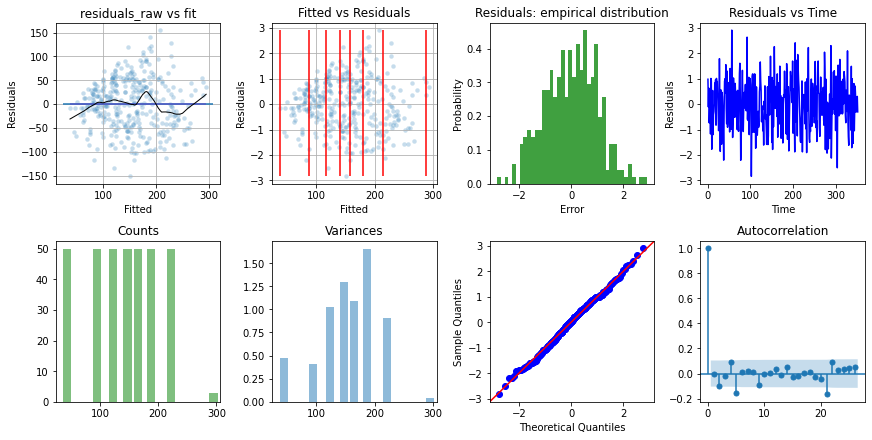

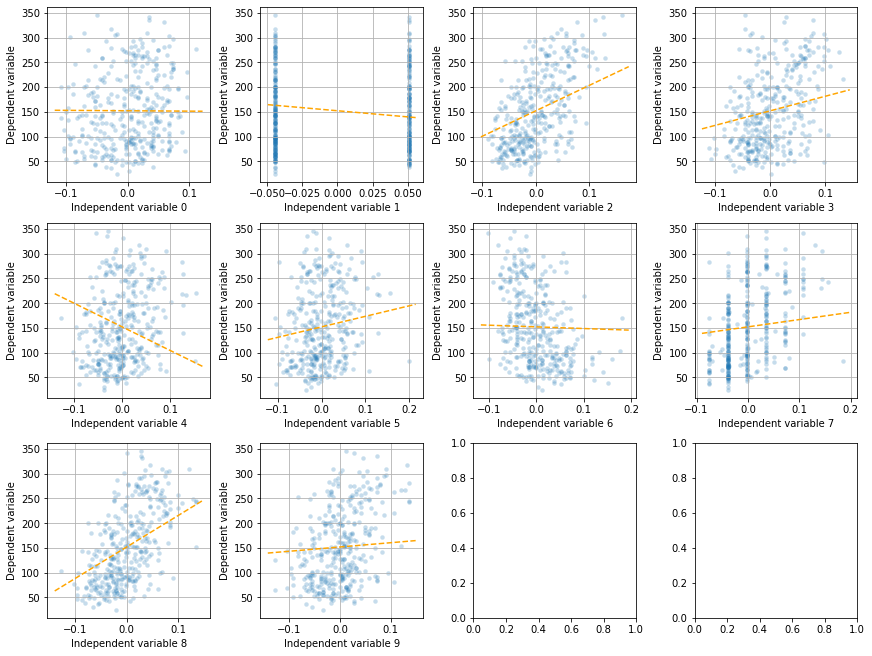

In [158]:
train_and_diagnose(X,y,draw_args={'variances_width':50,'variances_bin_type':'points'});

# Synthetic data

In [222]:
num_indep = 5
n_sample = 1000

X_base, y_base, coeffs = make_regression_custom(n_samples=n_sample, n_features=num_indep, n_informative=num_indep,
                   tail_strength=0, bias=10, n_targets=1, noise=0, 
                       shuffle=False, coef=True, random_state=2, custom_coef=[30,15,20])

X = X_base

not all coefficients present, reverted to random coeffs


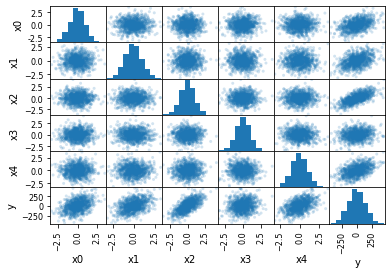

In [223]:
# df = pd.DataFrame(X_base)
df = data_to_df(X_base,y_base)

pd.plotting.scatter_matrix(df, alpha=0.2);

C:\Users\TK\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


<AxesSubplot:xlabel='x_name', ylabel='y_name'>

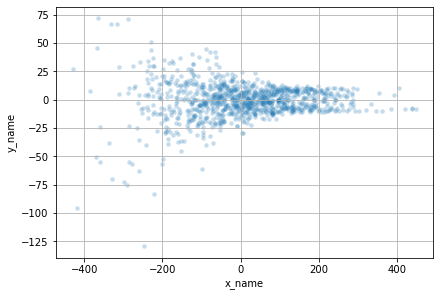

In [224]:
# yn0 = gen_noise(y_base,noise_coeff=100,noise_type="sin_index",n_osc=0.5)
# yn1 = yn0 + gen_noise(y_base,noise_coeff=30,noise_type="normal")
# y = y_base+yn1


# heteroskedatic noise on y
yn2 = gen_noise(y_base,1,noise_type="linear_inc_index", func=lambda x: np.log(np.abs(x)))*gen_noise(y_base,10,noise_type="normal")
# sinus in time 
yn3 = gen_noise(y_base,noise_coeff=10,noise_type="sin",n_osc=3) 

y = y_base+yn2+yn3

plot_x_vs_y(y_base,y-y_base)

Expected error estimate: 2.5313084961453567e-16


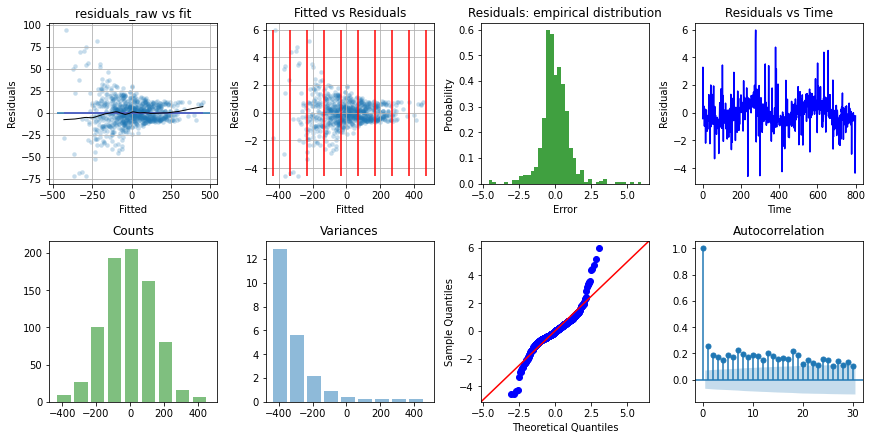

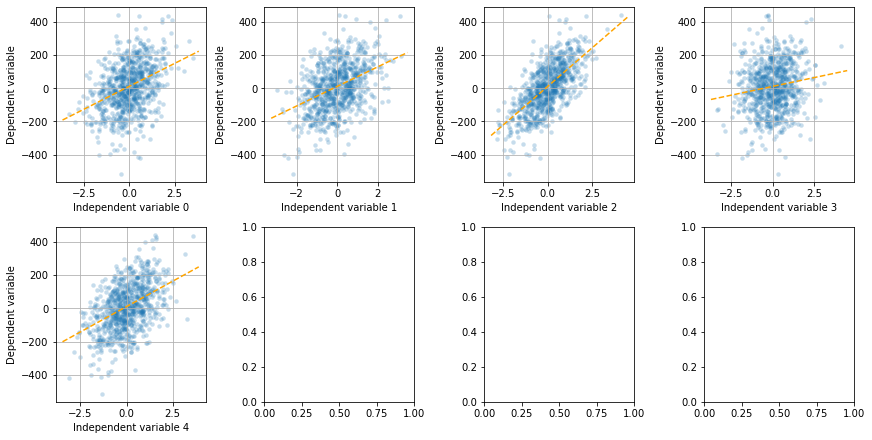

In [226]:
train_and_diagnose(X,y,draw_args={'variances_width':100,'variances_bin_type':'window'});

In [227]:
df_export = data_to_df(X,y)

In [228]:
df_export.to_csv('interesting_data.csv')

___

# Dumpster

In [5]:
y = theoretical_function_linear(X_base,coeffs,bias=10, y_noise_coeff=10, noise_type="sin_index", noise_args={"n_osc":2})

mean abs Y:  72.64541706985939
mean abs noise:  6.365862616931552
mean SNR:  inf


D:\ds_freelance\2021_amld_workshop\code\fantastic-features\dataset_noise_generator.py:122: RuntimeWarning: divide by zero encountered in true_divide
  print('mean SNR: ',(np.abs(Y_base/noise_y)).mean())


In [182]:
yn2 = gen_noise(y_base,1,noise_type="linear_inc_index", func=lambda x: np.log(np.abs(x)))*gen_noise(y_base,1,noise_type="normal")
# *gen_noise(y_base,1,noise_type="normal")

# y = y+yn2

C:\Users\TK\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


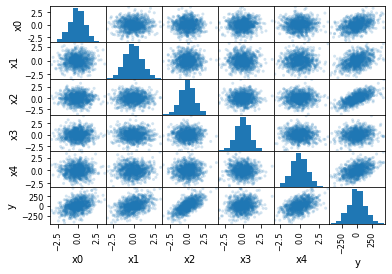

In [187]:
# df = pd.DataFrame(X_base)
df = data_to_df(X_base,y)

pd.plotting.scatter_matrix(df, alpha=0.2);

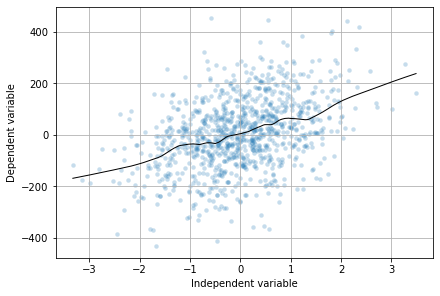

In [165]:
plot_x_vs_y(X_base[:,0], y, "Independent variable", "Dependent variable", 
                     add_zero_line=False, add_lowess=True,hexbin=False);

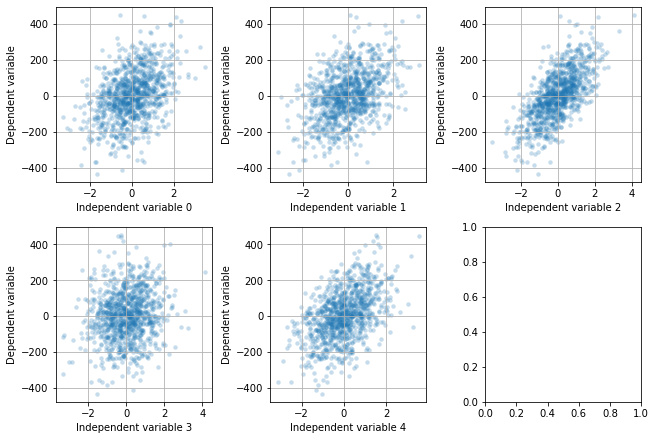

In [188]:
plot_multiple_x_vs_y(X_base, y, "Independent variable", "Dependent variable", 
                     add_regression_line=False, hexbin=False, n_col=3, plot_args={'s':20});

C:\Users\TK\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


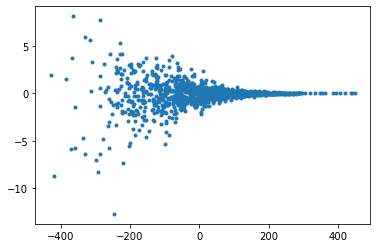

In [168]:
yn = gen_noise(y_base,1,noise_type="linear_inc_index", func=lambda x: np.log(np.abs(x)))*gen_noise(y_base,1,noise_type="normal")
# *gen_noise(y_base,1,noise_type="normal")

y = y_base+yn

plt.plot(y_base,yn,marker='.',lw=0)

Train-test split

# 2. Fit regression

In [31]:
threshold = int(len(X)*0.8)
X_train, X_test = X[:threshold], X[threshold:]
y_train, y_test = y[:threshold], y[threshold:]

predictors = sm.add_constant(X_train)
model = sm.OLS(y_train, predictors).fit()
fitted = model.predict(predictors)

residuals_raw = fitted - y_train
residuals = residuals_raw/np.std(residuals_raw)
print("Expected error estimate: {}".format(sum(residuals)/len(residuals)))
error_estimate = sum(residuals)/len(residuals)

variances_width = 100
variances_bin_type = 'window'

bins, variances, counts = calculate_variances(fitted, residuals, width=variances_width, bin_type=variances_bin_type)
# for v in variances:
#     print(v)


fig,ax = plt.subplots(ncols = 4, nrows = 2, figsize=(12,6), constrained_layout=True)

this_ax = ax[0,0]
plot_x_vs_y(fitted, residuals_raw, "Fitted", "Residuals", add_zero_line=True, add_lowess=True, ax=this_ax)
this_ax.set_title('residuals_raw vs fit')
xs = this_ax.get_xlim()
this_ax.hlines(error_estimate, xs[0], xs[1])

this_ax = ax[0,1]
plot_fitted_vs_residuals(fitted, residuals, mean=False, width=variances_width, bin_type=variances_bin_type, ax=this_ax)
resid_xlim = this_ax.get_xlim()

this_ax = ax[1,1]
this_ax.bar(bins, variances, width=np.diff(bins).min()*0.8, align='edge', alpha=0.5)
this_ax.set_title('Variances')
this_ax.set_xlim(resid_xlim)

this_ax = ax[1,0]
this_ax.bar(bins, counts, width=np.diff(bins).min()*0.8, align='edge', color='green', alpha=0.5)
this_ax.set_title('Counts')
this_ax.set_xlim(resid_xlim)


this_ax = ax[0,2]
plot_residuals_distribution(residuals, 40, ax=this_ax)

this_ax = ax[1,2]
ftmp = sm.qqplot(residuals/np.std(residuals), line='45', ax=this_ax);

this_ax = ax[0,3]
plot_x_over_time(residuals, "Residuals", ax=this_ax)

this_ax = ax[1,3]
ftmp = sg.tsaplots.plot_acf(residuals, ax=this_ax)


### 4.3 Residuals vs independent variables

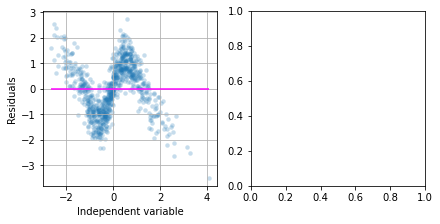

In [113]:
plot_multiple_x_vs_y(X_train, residuals, "Independent variable", "Residuals", 
                     add_regression_line=False, add_zero_line=True );

### 5.1 Correlation plot

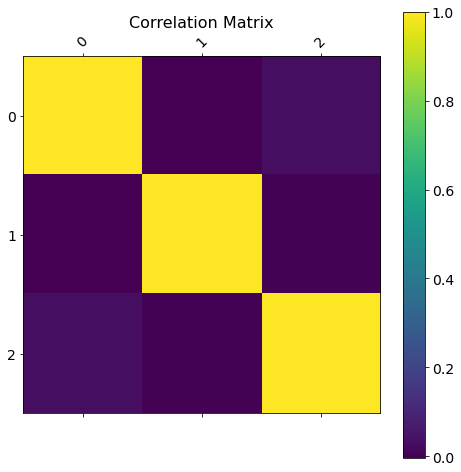

In [718]:
def plot_correlations(X: np.ndarray) -> None:
    df = pd.DataFrame(X)

    f = plt.figure(figsize=(8, 8))
    plt.matshow(df.corr(), fignum=f.number)
    plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
    plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title('Correlation Matrix', fontsize=16);

plot_correlations(X_train)